In [396]:
from pymongo import MongoClient
import pandas as pd
import matplotlib.pyplot as plt
from getpass import getpass
import requests
import pymongo


In [3]:
client = MongoClient("localhost:27017")
db = client["ironhack"]
c = db.get_collection("companies")

# Exploring Companies DB in Mongo

In [73]:
total_documents = c.count_documents({})

print(f"The number of companies in the DB is: {total_documents}")


The number of companies in the DB is: 18801


## Filter 1: Category

In [74]:

unique_categories = c.distinct("category_code")

unique_categories


[None,
 'advertising',
 'analytics',
 'automotive',
 'biotech',
 'cleantech',
 'consulting',
 'design',
 'ecommerce',
 'education',
 'enterprise',
 'fashion',
 'finance',
 'games_video',
 'government',
 'hardware',
 'health',
 'hospitality',
 'legal',
 'local',
 'manufacturing',
 'medical',
 'messaging',
 'mobile',
 'music',
 'nanotech',
 'network_hosting',
 'news',
 'nonprofit',
 'other',
 'photo_video',
 'public_relations',
 'real_estate',
 'search',
 'security',
 'semiconductor',
 'social',
 'software',
 'sports',
 'transportation',
 'travel',
 'web']

In [283]:

category = {"category_code":"games_video"}

n_games_video = c.count_documents({"category_code":"games_video"})

print(f"The number of companies in the gaming industry is: {n_games_video}")


The number of companies in the gaming industry is: 1083


## Filter 2: Countries

In [284]:
category = {"category_code":"games_video"}

unique_countries = c.distinct("offices.country_code", category)


In [285]:

pipeline = [
    {"$match": category},
    {"$group": {"_id": "$offices.country_code", "count": {"$sum": 1}}},
    {"$sort": {"count": -1}},
    {"$limit": 7} 
]

top_countries = c.aggregate(pipeline)

df = pd.DataFrame(top_countries)

df

,_id,count
0,[USA],487
1,[],244
2,[GBR],55
3,[CAN],32
4,"[USA, USA]",26
5,[FRA],22
6,[DEU],21


In [286]:
def drop_row(df):
    df = df.drop([1, 4]).reset_index(drop=True)
    return df
    
drop_row(df)


,_id,count
0,[USA],487
1,[GBR],55
2,[CAN],32
3,[FRA],22
4,[DEU],21


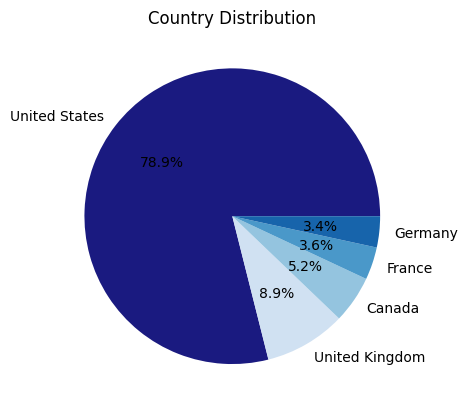

In [294]:
data = {'_id': ['[USA]', '[GBR]', '[CAN]', '[FRA]', '[DEU]'],
        'count': [487, 55, 32, 22, 21]}

df = pd.DataFrame(data)

country_mapping = {'[USA]': 'United States',
                   '[GBR]': 'United Kingdom',
                   '[CAN]': 'Canada',
                   '[FRA]': 'France',
                   '[DEU]': 'Germany'}

df = df.sort_values(by='count', ascending=False)

num_countries = len(df)
colors = [plt.cm.Blues(i / float(num_countries)) for i in range(num_countries)]

colors[0] = (0.1, 0.1, 0.5, 1.0) 

plt.pie(df['count'], labels=[country_mapping[code] for code in df['_id']], autopct='%1.1f%%', colors=colors)
plt.title('Country Distribution') 

country_distribution = "country_distribution.png"
plt.savefig(f"images/{country_distribution}")

plt.show()

In [288]:

category = {"category_code":"games_video"}
country = {"offices.country_code":"GBR"}

and_conditions = {"$and":[category, country]}

projection = {"_id":0, "name":1, "offices.country_code":1}

list(c.find(and_conditions, projection).limit(1))


[{'name': 'Babelgum', 'offices': [{'country_code': 'GBR'}]}]

In [246]:

total_documents = c.count_documents(and_conditions)

print(f"The number of companies after the two first filters is: {total_documents}")


The number of companies after the two first filters is: 72


## Filter 3: Cities

In [289]:
pipeline = [
    {"$match": category},
    {"$match": country},
    {"$group": {"_id": "$offices.city", "count": {"$sum": 1}}},
    {"$sort": {"count": -1}},
    {"$limit": 5} 
]

top_cities = c.aggregate(pipeline)

city_df = pd.DataFrame(top_cities)

city_df


,_id,count
0,[London],24
1,[Oxford],3
2,[Corby],3
3,[Dundee],2
4,[Newbury],2


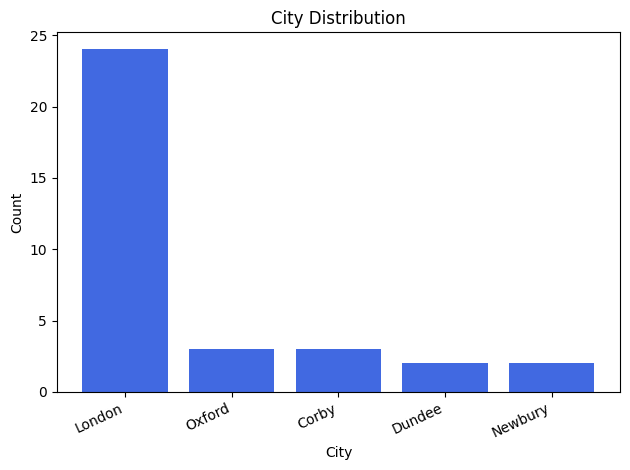

In [317]:

data = {'_id': ['[London]', '[Oxford]', '[Corby]', '[Dundee]', '[Newbury]'],
        'count': [24, 3, 3, 2, 2]}

df = pd.DataFrame(data)

cities = {'[London]': 'London',
          '[Oxford]': 'Oxford',
          '[Corby]': 'Corby',
          '[Dundee]': 'Dundee',
          '[Newbury]': 'Newbury'}

num_cities = len(df)

plt.bar(df['_id'].apply(lambda x: cities[x]), df['count'], color="royalblue")
plt.xlabel('City')
plt.ylabel('Count')
plt.title('City Distribution')

plt.xticks(rotation=25, ha='right')
plt.tight_layout()

city_distribution = "city_distribution.png"
plt.savefig(f"images/{city_distribution}")

plt.show()

In [302]:
category = {"category_code":"games_video"}
country = {"offices.country_code":"GBR"}
city = {"offices.city":"London"}

and_conditions = {"$and":[category, country, city]}

projection = {"_id":0, "name":1, "offices.country_code":1}

total_documents = c.count_documents(and_conditions)

print(f"The number of companies after the three filters is: {total_documents}")


The number of companies after the three first filters is: 35


## Filter 4: Latitude and Longitude

In [321]:

projection = {"_id":0, "name":1, "offices.city":1, "offices.latitude":1, "offices.longitude":1}

london_companies = list(c.find(and_conditions, projection))

london_companies

[{'name': 'Babelgum',
  'offices': [{'city': 'London',
    'latitude': 53.344104,
    'longitude': -6.267494}]},
 {'name': 'Tioti',
  'offices': [{'city': 'Seattle',
    'latitude': 47.733603,
    'longitude': -122.355579},
   {'city': 'London', 'latitude': 51.524323, 'longitude': -0.081169}]},
 {'name': 'blinkbox',
  'offices': [{'city': 'London',
    'latitude': 51.520779,
    'longitude': -0.10759}]},
 {'name': 'doof',
  'offices': [{'city': 'London', 'latitude': None, 'longitude': None}]},
 {'name': 'WorldTV',
  'offices': [{'city': 'Limerick',
    'latitude': 52.6638571,
    'longitude': -8.6267726},
   {'city': 'London', 'latitude': 51.5001524, 'longitude': -0.1262362}]},
 {'name': 'idiomag',
  'offices': [{'city': 'London',
    'latitude': 51.500152,
    'longitude': -0.126236}]},
 {'name': 'World Reviewer',
  'offices': [{'city': 'London', 'latitude': None, 'longitude': None}]},
 {'name': 'Playfish',
  'offices': [{'city': 'London',
    'latitude': 51.4991094,
    'longitude': 

## Creating a DF with the results

In [335]:

# 0. Filters

category = {"category_code":"games_video"}
country = {"offices.country_code":"GBR"}
city = {"offices.city":"London"}

# 1. Building the filters

and_conditions = {"$and":[category, country, city]}

# 3. Projection

projection = {"_id":0, "name":1, "offices.city":1, "offices.latitude":1, "offices.longitude":1}

final_companies = list(c.find(and_conditions, projection).sort("name", 1))

df  = pd.DataFrame(final_companies)

df

,name,offices
0,Astream,"[{'city': 'London', 'latitude': None, 'longitu..."
1,Babelgum,"[{'city': 'London', 'latitude': 53.344104, 'lo..."
2,Bandstocks,"[{'city': 'London', 'latitude': 51.5142132, 'l..."
3,BeatPick,"[{'city': 'London', 'latitude': 51.5001524, 'l..."
4,CareerPlayer,"[{'city': 'London', 'latitude': 51.5001524, 'l..."
5,Dilettante Music,"[{'city': 'London', 'latitude': None, 'longitu..."
6,Filmed Media,"[{'city': 'London', 'latitude': 51.5359008, 'l..."
7,Fragegg,"[{'city': 'Vienna', 'latitude': None, 'longitu..."
8,Get Closer,"[{'city': 'London', 'latitude': None, 'longitu..."
9,Illumina Digital,"[{'city': 'London', 'latitude': 51.503612, 'lo..."


## Exploding the nested information

In [363]:

df = pd.DataFrame(final_companies)

df_exploded = df.explode('offices')

london_companies = pd.concat([df_exploded.drop(['offices'], axis=1), df_exploded['offices'].apply(pd.Series)], axis=1)

london_companies


,name,city,latitude,longitude
0,Astream,London,NaN,NaN
1,Babelgum,London,53.344104,-6.267494
2,Bandstocks,London,51.514213,-0.126185
3,BeatPick,London,51.500152,-0.126236
3,BeatPick,Roma,41.895466,12.482324
4,CareerPlayer,London,51.500152,-0.126236
5,Dilettante Music,London,NaN,NaN
6,Filmed Media,London,51.535901,-0.205508
7,Fragegg,Vienna,NaN,NaN
7,Fragegg,London,NaN,NaN


## Cleaning the DF

In [406]:
def clean_df(df):

    df.dropna(thresh=3, inplace=True)
    df.rename(columns={'latitude': 'lat', 'longitude': 'lon'}, inplace=True)
    df = df[df['city'] == 'London'].reset_index(drop=True)
    df = df[df['lat'] <= 53].reset_index(drop=True)
    df = df[df['lat'] >= 50].reset_index(drop=True)
    df = df[df['lon'] > -1.2].reset_index(drop=True)
    return df

london_companies = clean_df(london_companies)

london_companies

,name,city,lat,lon
0,Bandstocks,London,51.514213,-0.126185
1,BeatPick,London,51.500152,-0.126236
2,CareerPlayer,London,51.500152,-0.126236
3,Filmed Media,London,51.535901,-0.205508
4,Illumina Digital,London,51.503612,-0.256280
5,Keen Software House,London,51.522076,-0.115300
6,Kramaley Games,London,51.494500,-0.147932
7,Mixcloud,London,51.539910,-0.285979
8,Pikum,London,51.539778,-0.152998
9,Playfish,London,51.499109,-0.198480


## Extracting results from FourSquare

In [375]:
token = getpass()

········


In [409]:
def find_things (venue, lat, lon, sort, limit):
         
    url = f"https://api.foursquare.com/v3/places/search?query={venue}&ll={lat}%2C{lon}&fields=name%2Cgeocodes&sort={sort}&limit={limit}"

    headers = {
        "accept": "application/json",
        "Authorization": token
    }

    response = requests.get(url, headers=headers).json()

    return response


def process_response_into_df (response):
    
    new_list = []

    for venue in response["results"]:

        name = venue["name"]
        lat = venue["geocodes"]["main"]["latitude"]
        lon = venue["geocodes"]["main"]["longitude"]

        dict_ = {
            "name": name,
            "lat": lat,
            "lon": lon
        }

        new_list.append(dict_)

    return pd.DataFrame(new_list)

def insert_df_into_mongo (df, collection):
    client = pymongo.MongoClient("localhost:27017")
    db = client["ironhack"]
    c = db.get_collection(collection) 
    
    for index, row in df.iterrows():
        c.insert_one(dict(row))


## Extracting Schools

In [432]:
# venue: what type of place are you looking (str), 
# lat: coordinate of latitude
# lon: coordinate of longitud 
# sort: popularity, relevance, rating, distance
# limit: limit of results you want to find (int)

coordinates_london = 51.5213009,-0.1976264

result_schools = find_things ("primary schools", "51.5213009", "-0.1976264", "popularity", "50")

schools_df = process_response_into_df (result_schools)

insert_df_into_mongo (schools_df, "schools")


In [433]:

schools_df


,name,lat,lon
0,Hallfield Primary School,51.514546,-0.185197
1,Salusbury Primary School,51.535937,-0.205658
2,Colville Primary School,51.514662,-0.203539
3,Fox Primary School Notting Hill,51.507669,-0.196881
4,St Clement & St James' C of E Primary School,51.509150,-0.211462
5,Avondale Park Primary School,51.510644,-0.214221
6,St Charles R C Primary School,51.521268,-0.215016
7,St Mary Magdalenes C of E Primary School,51.522425,-0.189118
8,Oxford Gardens Primary School,51.516883,-0.218499
9,Middle Row Primary School,51.525403,-0.212233


## Extracting Starbucks

In [435]:
# venue: what type of place are you looking (str), 
# lat: coordinate of latitude
# lon: coordinate of longitud 
# sort: popularity, relevance, rating, distance
# limit: limit of results you want to find (int)

coordinates_london = 51.5213009,-0.1976264

result_starbucks = find_things ("starbucks", "51.5213009", "-0.1976264", "rating", "50")

starbucks_df = process_response_into_df (result_starbucks)

insert_df_into_mongo (starbucks_df, "starbucks")


In [436]:

starbucks_df


,name,lat,lon
0,Starbucks,51.492085,-0.165586
1,Starbucks,51.514765,-0.150258
2,Starbucks,51.558758,-0.281940
3,Starbucks,51.545405,-0.162606
4,Starbucks,51.507335,-0.142500
5,Starbucks,51.494495,-0.182344
6,Starbucks,51.516025,-0.144089
7,Starbucks,51.524184,-0.389132
8,Starbucks,51.480623,-0.128149
9,Starbucks,51.559872,-0.278972


## Extracting Design Companies

In [438]:
# venue: what type of place are you looking (str), 
# lat: coordinate of latitude
# lon: coordinate of longitud 
# sort: popularity, relevance, rating, distance
# limit: limit of results you want to find (int)

result_design_companies = find_things ("design companies", "51.5213009", "-0.1976264", "rating", "50")

design_df = process_response_into_df (result_design_companies)

insert_df_into_mongo (design_df, "design companies")


In [439]:

design_df


,name,lat,lon
0,Ardesia Design,51.518700,-0.197059
1,Notting Hill Web Design,51.521392,-0.203121
2,Steffan Tollgard Interior Design,51.521430,-0.203465
3,Verus Design,51.521288,-0.204192
4,La Boca Design Studio,51.517581,-0.201311
5,Lovegrove Design Consultants,51.517380,-0.200975
6,Gemini Design,51.520306,-0.205521
7,The Pocket Library Design Archive Limited,51.515339,-0.197174
8,Design Concrete,51.514679,-0.195102
9,Nail Design,51.516794,-0.188047


## Exporting the final DFs

In [440]:

london_companies.to_csv('data/london_companies.csv', index=False)

schools_df.to_csv('data/schools_df.csv', index=False)

starbucks_df.to_csv('data/starbucks_df.csv', index=False)

design_df.to_csv('data/design_df.csv', index=False)
